In [90]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions
import numpy.random as npr
import qutip as qt
import sympy
import random

In [99]:
# seems N=10, J2=0.2 has only fail for 5 1s in a row
# N=10, J2=0.4 fails for 5 1s, but not necessarily in a row
# seems N=8, J2=0.4 has only fail for 4 1s in a row
N=10; J1=1; J2=0.2
h = j1j2_functions.J1J2_hamiltonian(N, J1, J2)
eigs = h.eigenstates()
gs = eigs[1][0]
gse = eigs[0][0]

In [112]:
threshold = 1e-10
statesf = []
signsf = []
for i in range(0, 2 ** N):
    val = gs[i][0].real
    if abs(val) > threshold: 
        statesf.append(i)
        signsf.append(-1 + 2 * int(val > 0))
pred_signsf =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesf]

print(len(statesf))
deviations = []
for state, true, calc in zip(statesf, signsf, pred_signsf):
    if true != calc:
        deviations.append(state)
        print(f'fail {bin(state)}, val {gs[state][0].real}, pred {calc}')
print(len(deviations))


252
fail 0b11111, val -5.154362876348855e-05, pred 1
fail 0b111110, val 5.15436287634932e-05, pred -1
fail 0b1111100, val -5.154362876348732e-05, pred 1
fail 0b11111000, val 5.154362876348707e-05, pred -1
fail 0b111110000, val -5.154362876348749e-05, pred 1
fail 0b1000001111, val 5.1543628763487176e-05, pred -1
fail 0b1100000111, val -5.1543628763487244e-05, pred 1
fail 0b1110000011, val 5.1543628763487115e-05, pred -1
fail 0b1111000001, val -5.154362876348747e-05, pred 1
fail 0b1111100000, val 5.15436287634872e-05, pred -1
10


In [101]:
input = utils.generate_input_samples(N, statesf)
labels = torch.tensor(signsf, dtype=torch.float64).reshape((-1, 1))
print(input.shape, labels.shape)

torch.Size([252, 10]) torch.Size([252, 1])


In [102]:
dataset = {'train_input': input, 'train_label': labels, 'test_input': input, 'test_label': labels}
bash_model2N = kan.KAN(width = [N, N, 1, 1])
bash_model2N(dataset['train_input'])
tanh = lambda x : torch.tanh(x)
bash_model2N.fix_symbolic(2, 0, 0, tanh)
bash_model2N.symbolic_fun[2].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype=torch.float64), requires_grad=False)

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1


In [ ]:
bash_model2N.fit(dataset, steps=20, lamb=0); # this seems to stay at loss = 0.28, (5 mistakes)

| train_loss: 2.82e-01 | test_loss: 2.82e-01 | reg: 8.42e+01 | : 100%|█| 20/20 [00:13<00:00,  1.50it

saving model version 0.2


In [104]:
bash_model2N(input)

tensor([[-0.9879],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [-1.0000],
        [ 0.9997],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 0.9994],
        [ 1.0000],
        [-1.0000],
        [ 0.9999],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 0.9997],
        [ 1.0000],
        [-0.9999],
        [-0.9972],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [ 0.9999],
        [-0.9997],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [-1.0000],
        [-1.0000],
        [ 0.9992],
        [-1.0000],
        [ 1.

In [105]:
labels

tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-

In [118]:
pred = bash_model2N(input)
pred_dev = []
for i in range(labels.shape[0]):
    if torch.sgn(pred[i][0])  != torch.sgn(labels[i][0]):
        pred_dev.append(i)
print(len(pred_dev))

5


In [123]:
torch.sqrt(torch.mean((pred - labels) ** 2)).item()

0.2817169850082281

In [122]:
torch.sqrt(torch.mean((torch.sgn(pred) - labels) ** 2)).item()

0.2817180849095055

In [117]:
torch.sgn(labels[0][0]) == torch.sgn(torch.tensor(-1))

tensor(True)

In [124]:
nlayer = 3
bash_model3N = kan.KAN(width = [N] * nlayer + [1, 1])
bash_model3N(dataset['train_input'])
tanh = lambda x : torch.tanh(x)
bash_model3N.fix_symbolic(nlayer, 0, 0, tanh)
bash_model3N.symbolic_fun[nlayer].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype=torch.float64), requires_grad=False)

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1


In [ ]:
bash_model3N.fit(dataset, steps=20, lamb=0); # omg this got to 1e-5, 0 mistakes

| train_loss: 1.04e-05 | test_loss: 1.04e-05 | reg: 1.39e+02 | : 100%|█| 20/20 [00:18<00:00,  1.10it

saving model version 0.2


In [128]:
pred3N = bash_model3N(input)
pred_dev3N = []
for i in range(labels.shape[0]):
    if torch.sgn(pred3N[i][0])  != torch.sgn(labels[i][0]):
        pred_dev3N.append(i)
print(len(pred_dev3N))

0


In [ ]:
bash_model3N.fit(dataset, steps=20, lamb=1e-5); # still no mistakes (2.8e-3 loss!)

| train_loss: 2.80e-03 | test_loss: 2.80e-03 | reg: 3.36e+01 | : 100%|█| 20/20 [00:34<00:00,  1.73s/

saving model version 0.3


In [130]:
pred3N = bash_model3N(input)
pred_dev3N = []
for i in range(labels.shape[0]):
    if torch.sgn(pred3N[i][0])  != torch.sgn(labels[i][0]):
        pred_dev3N.append(i)
print(len(pred_dev3N))

0


In [131]:
bash_model3N.prune().width

saving model version 0.4


[[10, 0], [8, 0], [2, 0], [1, 0], [1, 0]]

saving model version 0.4


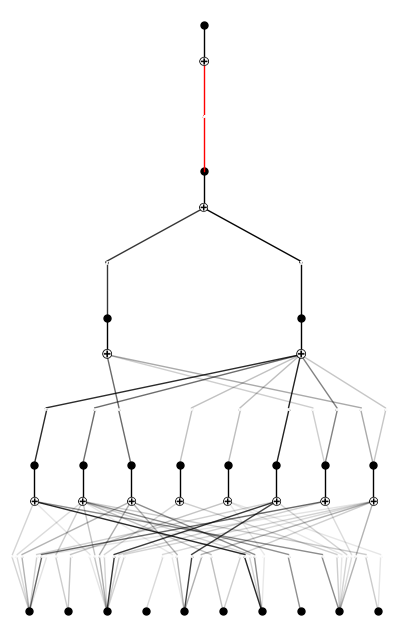

In [132]:
bash_model3N.prune().plot()

In [133]:
bash_model3N = bash_model3N.prune()
torch.sqrt(torch.mean((bash_model3N(input) - labels) ** 2))

saving model version 0.4


tensor(1.2908, dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [ ]:
bash_model3N.fit(dataset, steps=20); # after pruning gets stuck at 2 mistakes

| train_loss: 1.77e-01 | test_loss: 1.77e-01 | reg: 1.01e+02 | : 100%|█| 20/20 [00:11<00:00,  1.72it

saving model version 0.7


In [136]:
pred3N = bash_model3N(input)
pred_dev3N = []
for i in range(labels.shape[0]):
    if torch.sgn(pred3N[i][0])  != torch.sgn(labels[i][0]):
        pred_dev3N.append(i)
print(len(pred_dev3N))

2


In [227]:
nlayer = 3
rebash_model3N = kan.KAN(width = [N] * nlayer + [1, 1])
rebash_model3N(dataset['train_input'])
tanh = lambda x : torch.tanh(x)
rebash_model3N.fix_symbolic(nlayer, 0, 0, tanh)
rebash_model3N.symbolic_fun[nlayer].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype=torch.float64), requires_grad=False)

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1


In [ ]:
rebash_model3N.fit(dataset, steps=25, lamb=1e-4); # can get to 0 mistakes here (3e-3 loss) with 1e-5 lamb
# 0 mistakes 6e-3 loss with 5e-5 lamb
# 0 mistakes 9e-3 loss with 1e-4 lamb, took 2 tries though --> [[10, 0], [6, 0], [2, 0], [1, 0], [1, 0]] so far smallest structure

| train_loss: 8.59e-03 | test_loss: 8.59e-03 | reg: 2.43e+01 | : 100%|█| 25/25 [00:31<00:00,  1.27s/

saving model version 0.2


In [229]:
pred3N = rebash_model3N(input)
pred_dev3N = []
for i in range(labels.shape[0]):
    if torch.sgn(pred3N[i][0])  != torch.sgn(labels[i][0]):
        pred_dev3N.append(i)
print(len(pred_dev3N))

0


In [ ]:
rebash_model3N.prune().width

saving model version 0.3


[[10, 0], [6, 0], [2, 0], [1, 0], [1, 0]]

In [231]:
rebash_model3N = rebash_model3N.prune()
# rebash_model3N.symbolic_fun[nlayer].affine = nn.Parameter(rebash_model3N.symbolic_fun[nlayer].affine.data, requires_grad=False)
torch.sqrt(torch.mean((rebash_model3N(input) - labels) ** 2))

saving model version 0.3


tensor(0.8608, dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [232]:
pred3N = rebash_model3N(input)
pred_dev3N = []
for i in range(labels.shape[0]):
    if torch.sgn(pred3N[i][0]) != torch.sgn(labels[i][0]):
        pred_dev3N.append(i)
print(len(pred_dev3N))

52


In [233]:
rebash_model3N.fit(dataset, steps=30, lamb=2e-5, update_grid=False); # can train to 0 mistakes here, but often must say update grid false to prevent naning

| train_loss: 1.99e-03 | test_loss: 1.99e-03 | reg: 1.86e+01 | : 100%|█| 30/30 [00:19<00:00,  1.58it

saving model version 0.4


In [234]:
rebash_model3N.prune().width

saving model version 0.5


[[10, 0], [3, 0], [1, 0], [1, 0], [1, 0]]

In [235]:
rebash_model3N = rebash_model3N.prune()

saving model version 0.5


In [236]:
torch.sqrt(torch.mean((rebash_model3N(input) - labels) ** 2))

tensor(0.3398, dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [ ]:
rebash_model3N.fit(dataset, steps=30, lamb=1e-5, update_grid=False); 

| train_loss: 1.52e-03 | test_loss: 1.52e-03 | reg: 1.40e+01 | : 100%|█| 30/30 [00:11<00:00,  2.56it

saving model version 0.6


In [240]:
pred3N = rebash_model3N(input)
pred_dev3N = []
for i in range(labels.shape[0]):
    if torch.sgn(pred3N[i][0]) != torch.sgn(labels[i][0]):
        pred_dev3N.append(i)
print(len(pred_dev3N))

0


In [238]:
rebash_model3N.width

[[10, 0], [3, 0], [1, 0], [1, 0], [1, 0]]

In [245]:
rebash_model3N.saveckpt('model_files/best_bash_model_10_3_1_1_1')

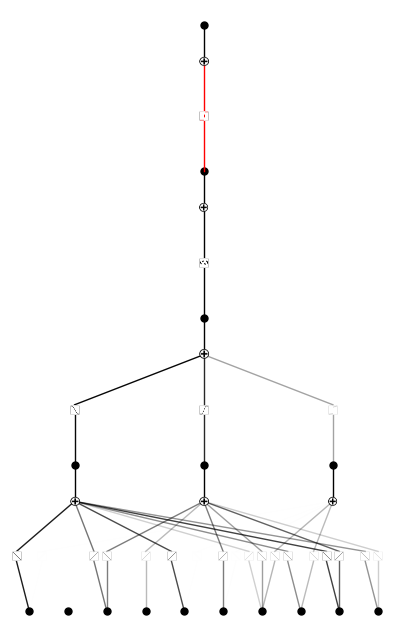

In [241]:
rebash_model3N.plot()

In [247]:
rebash_model3N.prune().width

saving model version 0.7


[[10, 0], [3, 0], [1, 0], [1, 0], [1, 0]]

In [248]:
rebash_model3N.fit(dataset, steps=30, lamb=2e-5, update_grid=False); 

| train_loss: 1.87e-03 | test_loss: 1.87e-03 | reg: 1.35e+01 | : 100%|█| 30/30 [00:12<00:00,  2.46it

saving model version 0.7


In [249]:
rebash_model3N.prune().width

saving model version 0.8


[[10, 0], [3, 0], [1, 0], [1, 0], [1, 0]]

In [250]:
rebash_model3N.fit(dataset, steps=30, lamb=5e-5, update_grid=False); 

| train_loss: 3.44e-03 | test_loss: 3.44e-03 | reg: 1.29e+01 | : 100%|█| 30/30 [00:11<00:00,  2.60it

saving model version 0.8


In [251]:
rebash_model3N.prune().width

saving model version 0.9


[[10, 0], [3, 0], [1, 0], [1, 0], [1, 0]]

In [252]:
rebash_model3N.fit(dataset, steps=30, lamb=7.5e-5, update_grid=False); 

| train_loss: 3.75e-03 | test_loss: 3.75e-03 | reg: 1.24e+01 | : 100%|█| 30/30 [00:11<00:00,  2.51it

saving model version 0.9


In [253]:
rebash_model3N.prune().width

saving model version 0.10


[[10, 0], [3, 0], [1, 0], [1, 0], [1, 0]]

In [254]:
rebash_model3N.fit(dataset, steps=30, lamb=1e-4, update_grid=False); 

| train_loss: 6.20e-03 | test_loss: 6.20e-03 | reg: 1.19e+01 | : 100%|█| 30/30 [00:12<00:00,  2.49it

saving model version 0.10


In [255]:
rebash_model3N.prune().width

saving model version 0.11


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [256]:
rebash_model3N = rebash_model3N.prune()

saving model version 0.11


In [257]:
rebash_model3N.fit(dataset, steps=30, lamb=1e-5, update_grid=False); 

| train_loss: 1.48e-03 | test_loss: 1.48e-03 | reg: 1.34e+01 | : 100%|█| 30/30 [00:10<00:00,  2.94it

saving model version 0.12


In [258]:
rebash_model3N.prune().width

saving model version 0.13


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [259]:
rebash_model3N.saveckpt('model_files/bash_model_10_2_1_1_1')

In [260]:
rebash_model3N.fit(dataset, steps=30, lamb=1e-4, update_grid=False); 

| train_loss: 4.55e-03 | test_loss: 4.55e-03 | reg: 1.27e+01 | : 100%|█| 30/30 [00:09<00:00,  3.05it

saving model version 0.13


In [261]:
rebash_model3N.prune().width

saving model version 0.14


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [262]:
rebash_model3N.fit(dataset, steps=30, lamb=2e-4, update_grid=False); 

| train_loss: 7.53e-03 | test_loss: 7.53e-03 | reg: 1.21e+01 | : 100%|█| 30/30 [00:10<00:00,  2.96it

saving model version 0.14


In [263]:
rebash_model3N.prune().width

saving model version 0.15


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [264]:
rebash_model3N.fit(dataset, steps=30, lamb=4e-4, update_grid=False); 

| train_loss: 7.89e-03 | test_loss: 7.89e-03 | reg: 1.20e+01 | : 100%|█| 30/30 [00:10<00:00,  2.91it

saving model version 0.15


In [265]:
rebash_model3N.fit(dataset, steps=30, lamb=8e-4, update_grid=False); 

| train_loss: 1.07e-02 | test_loss: 1.07e-02 | reg: 1.18e+01 | : 100%|█| 30/30 [00:10<00:00,  2.82it

saving model version 0.16


In [266]:
rebash_model3N.prune().width

saving model version 0.17


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [267]:
rebash_model3N.fit(dataset, steps=30, lamb=1e-3, update_grid=False); 

| train_loss: 9.91e-03 | test_loss: 9.91e-03 | reg: 1.15e+01 | : 100%|█| 30/30 [00:09<00:00,  3.03it

saving model version 0.17


In [268]:
rebash_model3N.prune().width

saving model version 0.18


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [269]:
rebash_model3N.fit(dataset, steps=30, lamb=2e-3, update_grid=False); 

| train_loss: 1.72e-02 | test_loss: 1.72e-02 | reg: 1.12e+01 | : 100%|█| 30/30 [00:10<00:00,  2.92it

saving model version 0.18


In [270]:
rebash_model3N.prune().width

saving model version 0.19


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

In [271]:
rebash_model3N.fit(dataset, steps=30, lamb=4e-3, update_grid=False); 

| train_loss: 2.29e-02 | test_loss: 2.29e-02 | reg: 1.11e+01 | : 100%|█| 30/30 [00:05<00:00,  5.45it

saving model version 0.19


In [272]:
rebash_model3N.prune().width

saving model version 0.20


[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]